## Load Data

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

#  Import and read the data
application_df = pd.read_csv("./Resources/Numbers_OMDB_FINAL.csv")
application_df.head()

Using TensorFlow backend


,Unnamed: 0,Movie,ProductionBudget,DomesticGross,WorldwideGross,OMDB_Title,OMDB_Rated,OMDB_Runtime,OMDB_Genre,OMDB_Director,...,ReleaseMonth,Director_Avg_Box,Director_Avg_Rating,Director_Score,Writer_Avg_Box,Writer_Avg_Rating,Writer_Score,Actor_Avg_Box,Actor_Avg_Rating,Actor_Score
0,0,Avatar: The Way of Water,460000000,684075767,2319591720,Avatar: The Way of Water,teens,192.0,"Action, Adventure, Fantasy",James Cameron,...,12.0,3.342183e+08,7.91,14.60,2.850750e+08,7.33,13.03,1.616679e+08,6.53,9.77
1,1,Avengers: Endgame,400000000,858373000,2788912285,Avengers: Endgame,teens,181.0,"Action, Adventure, Drama","Anthony Russo, Joe Russo",...,4.0,NaN,7.18,NaN,4.218914e+08,7.16,15.53,1.688389e+08,6.97,10.38
2,2,Pirates of the Caribbean: On Stranger Tides,379000000,241071802,1045713802,Pirates of the Caribbean: On Stranger Tides,teens,136.0,"Action, Adventure, Fantasy",Rob Marshall,...,5.0,1.314813e+08,6.58,9.21,1.762009e+08,6.81,10.33,8.391134e+07,6.50,8.44
3,3,Avengers: Age of Ultron,365000000,459005868,1395316979,Avengers: Age of Ultron,teens,141.0,"Action, Adventure, Sci-Fi",Joss Whedon,...,5.0,3.513501e+08,7.78,14.81,3.273985e+08,6.71,13.71,1.688389e+08,6.97,10.38
4,4,Fast X,340000000,145960660,714414576,Fast X,teens,141.0,"Action, Adventure, Crime",Louis Leterrier,...,5.0,1.081561e+08,6.31,8.48,9.776042e+07,5.97,7.81,9.731984e+07,6.17,8.09


In [2]:
application_df.columns

Index(['Unnamed: 0', 'Movie', 'ProductionBudget', 'DomesticGross',
       'WorldwideGross', 'OMDB_Title', 'OMDB_Rated', 'OMDB_Runtime',
       'OMDB_Genre', 'OMDB_Director', 'OMDB_Writer', 'OMDB_Actors',
       'OMDB_Language', 'OMDB_Country', 'OMDB_Metascore', 'OMDB_imdbRating',
       'OMDB_imdbVotes', 'OMDB_BoxOffice', 'OMDB_Production', 'ReleaseYear',
       'ReleaseMonth', 'Director_Avg_Box', 'Director_Avg_Rating',
       'Director_Score', 'Writer_Avg_Box', 'Writer_Avg_Rating', 'Writer_Score',
       'Actor_Avg_Box', 'Actor_Avg_Rating', 'Actor_Score'],
      dtype='object')

## Select the data to be used in the model

**Features**
* Our customer is the Writer, Director combo evaluating how the movie might do before pulling in actors so we are using Writer & Director ratings
* While our initial data review did not show a relationship between release month and movie rating, it did show a relationship to box office returns so we are going to keep it in as a potential complex additive
* Budget alone had almost no relationship with movie rating; however, we are going to keep it in as a potential complex additive
* Runtime showed a very small relationship to IMDB rating alone

Note: kids vs. teens vs. adults as considered but showed little relevance in early experiments

**Target**

Our customers want to understand how popular the movie will be so we will be using the IMDB Rating.

In [3]:
# Create the dataframe for the features and target
df_rating = application_df[['ProductionBudget', 'Director_Avg_Rating', 'OMDB_Runtime', 
                            'ReleaseMonth', 'Writer_Avg_Rating', 'OMDB_imdbRating']]
# Drop rows with NaN values
df_rating = df_rating.dropna()

# View the dataframe and row count
print(len(df_rating))
df_rating.head()

5542


,ProductionBudget,Director_Avg_Rating,OMDB_Runtime,ReleaseMonth,Writer_Avg_Rating,OMDB_imdbRating
0,460000000,7.91,192.0,12.0,7.33,7.6
1,400000000,7.18,181.0,4.0,7.16,8.4
2,379000000,6.58,136.0,5.0,6.81,6.6
3,365000000,7.78,141.0,5.0,6.71,7.3
4,340000000,6.31,141.0,5.0,5.97,5.8


## Split the data into training and test sets

In [4]:
# Define features as X, target as y
y = df_rating['OMDB_imdbRating']
X = df_rating.drop(columns='OMDB_imdbRating')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scale the data

In [5]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Define the Random Forest Regression model; train it, test it, evaluate it

In [6]:
# Initialize the Random Forest Regressor
rf_model_rating = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model_rating.fit(X_train_scaled, y_train)

# Make predictions on the test set
rating_predictions = rf_model_rating.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, rating_predictions)
print(f'Mean Squared Error: {mse}')

# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model_rating.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model_rating.feature_importances_, X.columns), reverse=True)

Mean Squared Error: 0.20949117132551856


[(0.7650085946133273, 'Writer_Avg_Rating'),
 (0.1506891806639987, 'Director_Avg_Rating'),
 (0.034104837973160156, 'ProductionBudget'),
 (0.03110344823736731, 'OMDB_Runtime'),
 (0.019093938512146535, 'ReleaseMonth')]

## Plot the predictions and actuals together for Test Data

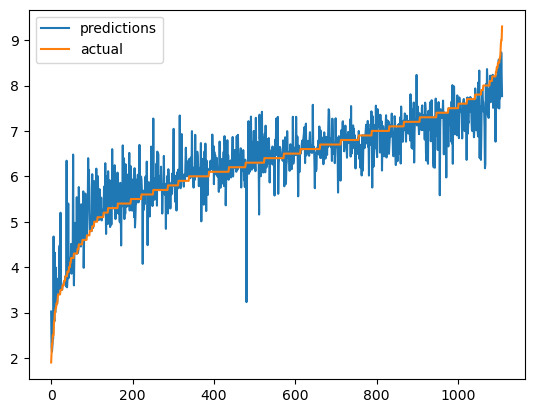

In [7]:
# Create a dataframe for the actual and prediction values
test_compare = pd.DataFrame({'orig_index':y_test.index, 'actual':y_test.values})
test_compare['predictions'] = rating_predictions
test_compare = test_compare.sort_values('actual').reset_index(drop=True)

# Plot the dataframe
# test_compare = test_compare[['predictions', 'actual']]
test_lines = test_compare[['predictions', 'actual']].plot.line()

## Check model predictions of training data against actual training data

In [8]:
# Check the model against the training data - if mse is much lower than the model is overfitting
y_train_pred = rf_model_rating.predict(X_train_scaled)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_train

0.02545556778705168

## Plot the predictions and actuals together for Training Data

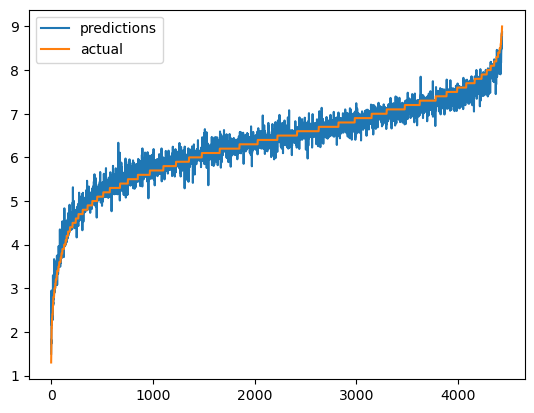

In [9]:
# Create a dataframe for the actual and prediction values
train_compare = pd.DataFrame({'orig_index':y_train.index, 'actual':y_train.values})
train_compare['predictions'] = y_train_pred
train_compare = train_compare.sort_values('actual').reset_index(drop=True)

# Plot the dataframe
# train_compare = train_compare[['predictions', 'actual']]
train_lines = train_compare[['predictions', 'actual']].plot.line()

# Applying Keras Tuner

In [10]:
# Define the keras tuner parameters
def create_model(hp):
    movie_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    # Allow kerastuner to decide which optimizer
    optimizer = hp.Choice('opt', values=['adam', 'sgd', 'rmsprop'])
    
    # Allow kerastuner to decide number of neurons in first layer
    movie_model.add(tf.keras.layers.Dense(units=hp.Int('first_units', min_value=1, max_value=10, step=2), 
                                          activation=activation, input_dim=5))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        movie_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))

    movie_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Compile the model
    movie_model.compile(loss="mse", optimizer=optimizer, metrics=[tf.keras.metrics.MeanSquaredError()])

    return movie_model

In [11]:
tuner = kt.Hyperband(
    create_model,
    objective="val_loss",
    max_epochs=20,
    hyperband_iterations=2, 
    project_name='movie_makers')

Reloading Tuner from .\movie_makers\tuner0.json


In [12]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

In [13]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'relu',
 'opt': 'rmsprop',
 'first_units': 5,
 'num_layers': 2,
 'units_0': 9,
 'units_1': 5,
 'units_2': 7,
 'units_3': 7,
 'units_4': 7,
 'units_5': 7,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0050'}

In [14]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, MSE: {model_accuracy}")

35/35 - 0s - loss: 29.3803 - mean_squared_error: 29.3803 - 306ms/epoch - 9ms/step
Loss: 29.38028907775879, MSE: 29.38028907775879


In [15]:
# Check the model against the training data - if mse is much lower than the model is overtraining
model_loss_train, model_accuracy_train = best_model.evaluate(X_train_scaled,y_train,verbose=2)
print(f"Loss: {model_loss_train}, MSE: {model_accuracy_train}")

139/139 - 0s - loss: 29.5945 - mean_squared_error: 29.5945 - 280ms/epoch - 2ms/step
Loss: 29.594507217407227, MSE: 29.594507217407227


In [16]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 dense_1 (Dense)             (None, 9)                 54        
                                                                 
 dense_2 (Dense)             (None, 5)                 50        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 140 (560.00 Byte)
Trainable params: 140 (560.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Merge Dataframes to have a single Dataframe of Features + Target + Prediction

In [17]:
print(f'df_rating length: {len(df_rating)}')
df_rating.head(2)

df_rating length: 5542


,ProductionBudget,Director_Avg_Rating,OMDB_Runtime,ReleaseMonth,Writer_Avg_Rating,OMDB_imdbRating
0,460000000,7.91,192.0,12.0,7.33,7.6
1,400000000,7.18,181.0,4.0,7.16,8.4


In [18]:
print(f'test_compare length: {len(test_compare)}')
test_compare.head(3)

test_compare length: 1109


,orig_index,actual,predictions
0,2732,1.9,3.023
1,4101,2.1,2.239
2,460,2.3,2.137


In [19]:
print(f'train_compare length: {len(train_compare)}')
train_compare.head(2)

train_compare length: 4433


,orig_index,actual,predictions
0,1422,1.3,1.501
1,2760,1.5,1.825


In [20]:
predict_compare = pd.concat([test_compare, train_compare])
print(f'predict_compare length: {len(predict_compare)}')
predict_compare.head(2)

predict_compare length: 5542


,orig_index,actual,predictions
0,2732,1.9,3.023
1,4101,2.1,2.239


In [21]:
movie_predictions = df_rating.merge(predict_compare, left_on=df_rating.index, right_on='orig_index')
movie_predictions

,ProductionBudget,Director_Avg_Rating,OMDB_Runtime,ReleaseMonth,Writer_Avg_Rating,OMDB_imdbRating,orig_index,actual,predictions
0,460000000,7.91,192.0,12.0,7.33,7.6,0,7.6,7.766
1,400000000,7.18,181.0,4.0,7.16,8.4,1,8.4,8.268
2,379000000,6.58,136.0,5.0,6.81,6.6,2,6.6,6.655
3,365000000,7.78,141.0,5.0,6.71,7.3,3,7.3,7.287
4,340000000,6.31,141.0,5.0,5.97,5.8,4,5.8,5.714
...,...,...,...,...,...,...,...,...,...
5537,7000,6.00,80.0,3.0,6.00,6.0,5665,6.0,6.016
5538,7000,7.80,84.0,4.0,7.80,7.8,5666,7.8,7.784
5539,7000,6.50,86.0,6.0,5.62,5.0,5667,5.0,6.169
5540,6000,8.19,69.0,11.0,8.18,7.5,5668,7.5,7.783


In [22]:
movie_predictions.to_csv("./Resources/movie_maker_model_results.csv")